# LoadsKit Example
The following example will help familiarize you with some of the functions in the mhkit loads module that you can use to assist you in your loads analysis. 

We will start with some import statements that are needed for this example. 

In [1]:
# import statements
import pandas as pd 
import numpy as np 
from mhkit import utils
from mhkit import loadsKit as lk 
import matplotlib.pyplot as plt 
import os
from scipy.io import loadmat # used to work with matlab files

In this example, since there is no known field loads data for MH devices, this data comes from a land based wind turbine. We have a database of 364 .mat files, each containing 10 minutes of data sampled at 50Hz. 

As a start, lets look at the data for one of these files to figure out what formatting we need to apply. We use the loadmat module to help us import the .mat files. This gives us a dictionary which we can then flatten to extract the meaningful data. This data did not have headers so we imported a text file that contained the corresponding variable names for each column. We then initiate the dataframe and peek into what the data looks like. 

In [2]:
# import mat files and calculate stats for each one
pathOut = '../workspace/data_GE/'
f_example = loadmat(pathOut+'test/turbine_2017_03_01_01_28_41.mat')
# extract data from dict
data_example = [[row.flat[0] for row in line] for line in f_example['data_new']]
# import txt file containing header and unit information
headers = pd.read_csv(pathOut+'headers.txt',sep='\t',header=None)
# turn into dataframe
df_example = pd.DataFrame(data_example,columns=headers[0])
df_example.head()

,Timestamp,Time,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
0,42795.061586,0.00,3.226754,1.0,157.302829,157.279582,-41.380694,-234.487436,-6.207381,-70.130726,-936.247028,-12.605151,-330.410779,1024.816867,470.774738,-165.541786,33.427748,-59.452360,-5.279680,0.023247
1,42795.061586,0.02,3.221099,1.0,157.302829,157.279582,-38.614459,-233.715870,-8.886200,-66.916338,-942.675906,-24.350452,-315.445562,873.214212,469.244736,-163.588005,32.697822,-62.300637,-5.671178,0.023247
2,42795.061586,0.04,3.223492,1.0,157.302829,157.279582,-39.717967,-234.341966,-7.970862,-67.860011,-922.971018,-22.485796,-292.252115,876.299461,468.736474,-166.018111,35.495810,-61.733604,-5.551847,0.023247
3,42795.061586,0.06,3.223274,1.0,157.302829,157.279582,-41.415143,-235.645598,-10.451794,-72.371951,-939.515265,-33.030892,-274.812769,763.833828,467.373452,-164.645639,37.952455,-64.390050,-4.626557,0.023247
4,42795.061587,0.08,3.223927,1.0,157.302829,157.279582,-38.614459,-234.755991,-8.648988,-76.530014,-924.771486,-29.228398,-310.213400,704.537757,466.318754,-161.233863,37.430668,-65.974766,-4.708621,0.023247


In MHKit, it is important to format your dataframes so that they are indexed by time. Our file above shows us that we have two references to time, but neither are in the right format. The "Timestamp" column is what will give us the datetime index that we are looking for, but we first need to convert it from microsoft excel format to pd.Datetime. 

In [3]:
# use the datetime conversion function from the utils module
newtime = utils.excel2datetime(df_example['Timestamp'])
# replace the timestamp column with our newly formatted datetime
df_example['Timestamp'] = newtime 
# set this as our index for our dataframe
df_example = df_example.set_index('Timestamp')
# remove the "time" column as its unnecessary 
df_example.drop(columns='Time',inplace=True)
df_example.head()

,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
Timestamp,,,,,,,,,,,,,,,,,,
2017-03-01 01:28:40.999987200,3.226754,1.0,157.302829,157.279582,-41.380694,-234.487436,-6.207381,-70.130726,-936.247028,-12.605151,-330.410779,1024.816867,470.774738,-165.541786,33.427748,-59.452360,-5.279680,0.023247
2017-03-01 01:28:41.020032000,3.221099,1.0,157.302829,157.279582,-38.614459,-233.715870,-8.886200,-66.916338,-942.675906,-24.350452,-315.445562,873.214212,469.244736,-163.588005,32.697822,-62.300637,-5.671178,0.023247
2017-03-01 01:28:41.039990400,3.223492,1.0,157.302829,157.279582,-39.717967,-234.341966,-7.970862,-67.860011,-922.971018,-22.485796,-292.252115,876.299461,468.736474,-166.018111,35.495810,-61.733604,-5.551847,0.023247
2017-03-01 01:28:41.060035200,3.223274,1.0,157.302829,157.279582,-41.415143,-235.645598,-10.451794,-72.371951,-939.515265,-33.030892,-274.812769,763.833828,467.373452,-164.645639,37.952455,-64.390050,-4.626557,0.023247
2017-03-01 01:28:41.079993600,3.223927,1.0,157.302829,157.279582,-38.614459,-234.755991,-8.648988,-76.530014,-924.771486,-29.228398,-310.213400,704.537757,466.318754,-161.233863,37.430668,-65.974766,-4.708621,0.023247


Now that we have our file in the right format, we can start to do some analysis. Lets say that we wanted to investigate fatigue. We can do this by calculating short-term damage equivalent loads (DELs). To use this function, we first need to make a tuple/list that contains the variable we want to analyze and its corresonding material slope factor. In this instance, we want to just look at our tower base moment and our blade 1 root flap moment. Our tower is steel while our blade is composite so they will have different material slopes. 

We call our function and apply the default inputs of using at least 100 bins for the load ranges and we let t=600 seconds so that we get an equivalent 1Hz DEL for our 10 minute file. 

In [4]:
# define the tuple/list variable that contains the variable name and corresponding material slope factor
var_dict = [
    ('TB_ForeAft',4),
    ('BL1_FlapMom',10)
]
# use the get_DELs function to calculate the damage equivalent load for this file
DEL = lk.get_DELs(df_example,var_dict,binNum=100,t=600)
DEL

,TB_ForeAft,BL1_FlapMom
0,3914.395539,1435.906826


Another important part of loads analysis is looking at statistics. Here, we use another function to help us calculate the mean, max, min, and std for this 10 minute file. Per standards, a valid statistical window has to be consecutive in time with the correct number of datapoints. So if this 10 minute file did meet this criteria, then no stats would be generated and a warning message would appear. 

NOTE: Sometimes individual files may contain enough data for multiple statistical windows. This function can still handle this scenario as long as the correct inputs are specified.  

In [5]:
# calculate the means, maxs, mins, and stdevs of this file
means,maxs,mins,stdevs = utils.get_stats(df_example,50,period=600)
# show the results which is indexed by the first timestamp of the corresponding statistical window
means

,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
2017-03-01 01:28:41,7.773325,1.0,178.612256,178.602595,127.244191,-252.23813,3.50322,7.032573,-846.663367,271.446574,3785.034515,7.199176,-494.858287,266.790368,-452.652744,21.259999,234.578289,0.009661


At this point, it would be nice to start visualizing some of this data by making plots. In order to do this, we need to calculate the stats and DELs for all the files in our database. Below is a loop that imports each file and applies all the functions we just saw. At the end of the loop, we store the result by appending to a list (this is computationally more efficient than concatenating dataframes). Finally, we can convert our lists to dataframes so that its easier to play with the data. 

In [6]:
# pre-allocate lists for storage
means = []
maxs = []
mins = []
stdev = []
DELlist = []

# start loop
for f in os.listdir(pathOut):
    if f.endswith('.mat'):
        # import mat file
        matfile = loadmat(pathOut+'/'+f)
        # extract data from dict and turn into dataframe
        data = [[row.flat[0] for row in line] for line in matfile['data_new']]
        df = pd.DataFrame(data,columns=headers[0])
        # replace the timestamp column with formatted datetime
        df['Timestamp'] = utils.excel2datetime(df['Timestamp']) 
        # set this as our index for our dataframe
        df = df.set_index('Timestamp')
        # remove the "time" column as its unnecessary 
        df.drop(columns='Time',inplace=True)
        # get stats
        fmean, fmax, fmin, fstd = utils.get_stats(df,freq=50,period=600)
        means.append(fmean.values.tolist())
        maxs.append(fmax.values.tolist())
        mins.append(fmin.values.tolist())
        stdev.append(fstd.values.tolist())

        # start fatigue calc
        dfDEL = lk.get_DELs(df,var_dict)
        DELlist.extend(dfDEL.values.tolist()) 

In [7]:
# store lists into dataframes
dfmeans = pd.DataFrame(np.squeeze(means),columns=df.columns.values)
dfmaxs = pd.DataFrame(np.squeeze(maxs),columns=df.columns.values)
dfmins = pd.DataFrame(np.squeeze(mins),columns=df.columns.values)
dfstd = pd.DataFrame(np.squeeze(stdev),columns=df.columns.values)
dfDELs = pd.DataFrame(np.squeeze(DELlist),columns=dfDEL.columns.values)

Now that we have all of our stats, lets make a scatter plot that can give us a visual. Using the statplotter function, we can quickly create a standard scatter plot showing how load variables trend with wind speed. You can fillout the saveplot flag if you would like to save the figure to a specific location. Using this we can quickly spot expected trends and track down outliers. 

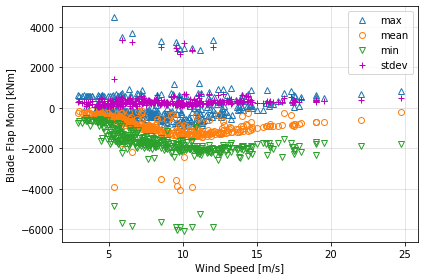

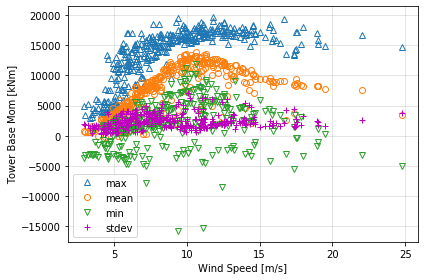

In [8]:
lk.statplotter(dfmeans['uWind_80m'],dfmeans['BL1_FlapMom'],dfmaxs['BL1_FlapMom'],dfmins['BL1_FlapMom'],vstdev=dfstd['BL1_FlapMom'],xlabel='Wind Speed [m/s]',ylabel='Blade Flap Mom [kNm]')
lk.statplotter(dfmeans['uWind_80m'],dfmeans['TB_ForeAft'],dfmaxs['TB_ForeAft'],dfmins['TB_ForeAft'],vstdev=dfstd['TB_ForeAft'],xlabel='Wind Speed [m/s]',ylabel='Tower Base Mom [kNm]')

Another common step is to bin the statistical data. This can easily be done with another function from loadsKit shown below. A warning message will show if there are any bins that were not filled. 

In [9]:
# create array containg wind speeds to use as bin edges
b_edges = np.arange(3,26,1)
# apply function for means, maxs, mins, and DELs 
[bin_means, bin_means_std] = lk.bin_stats(dfmeans,dfmeans['uWind_80m'],b_edges)
[bin_maxs, bin_maxs_std] = lk.bin_stats(dfmaxs,dfmeans['uWind_80m'],b_edges)
[bin_mins, bin_mins_std] = lk.bin_stats(dfmins,dfmeans['uWind_80m'],b_edges)
[bin_DELs, bin_DELs_std] = lk.bin_stats(dfmaxs,dfmeans['uWind_80m'],b_edges)

bin_means.head()

,uWind_80m,WD_ModActive,WD_Nacelle,WD_NacelleMod,LSSDW_Tq,LSSDW_My,LSSDW_Mz,TTTq,TT_ForeAft,TT_SideSide,TB_ForeAft,TB_SideSide,BL3_FlapMom,BL3_EdgeMom,BL1_FlapMom,BL1_EdgeMom,ActivePower,yawoffset
0,3.582788,1.000000,179.116583,179.215605,29.890756,-252.235192,-2.931479,-26.271654,-932.953738,126.807011,994.638671,-102.050137,-206.591291,129.390923,-238.085263,-14.874877,21.370858,-0.099022
1,4.506286,1.000000,179.249204,179.244519,80.089764,-248.264369,-3.823860,-54.228710,-850.673089,152.471374,2297.495697,60.126271,-334.995082,161.690594,-363.734773,-6.333188,77.600575,0.004684
2,5.532089,0.980000,180.242787,180.223322,173.853052,-230.822358,-2.946037,-50.260605,-757.746017,215.205459,3859.250119,141.020992,-499.066411,190.755437,-606.245368,1465.092348,169.540256,0.019465
3,6.533127,0.971429,180.884821,180.839518,213.378279,-238.142324,-5.800559,-45.130341,-655.735140,297.140560,5956.993512,193.000373,-692.423706,233.699062,-759.628593,583.487498,309.593662,0.045303
4,7.525571,1.000000,181.611905,181.715015,289.022609,-241.151609,-9.332181,-61.012744,-563.549959,378.458393,7682.730532,306.618709,-875.113999,250.133361,-889.196574,90.830559,458.634948,-0.103111


Now lets make some more plots with the binned data. Here we use the binned data and corresponding standard deviation in each bin to make an errorbar plot. 

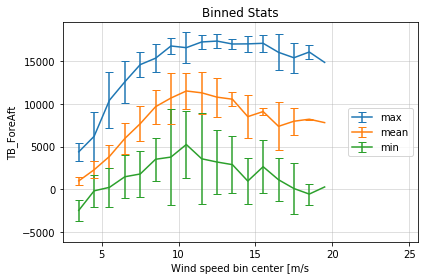

In [10]:
bcenters = np.arange(3.5,25.5,step=1) # the center of each wind speed bin
variab = 'TB_ForeAft' # name of the variable we want to analyze
# decleration of inputs to be used in plotting
bmean = bin_means[variab]
bmax = bin_maxs[variab]
bmin = bin_mins[variab]
bstdmean = bin_means_std[variab]
bstdmax = bin_maxs_std[variab]
bstdmin = bin_mins_std[variab]

# create plot
fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(bcenters,bmax,yerr=bstdmax,capsize=4,label='max')
ax.errorbar(bcenters,bmean,yerr=bstdmean,capsize=4,label='mean')
ax.errorbar(bcenters,bmin,yerr=bstdmin,capsize=4,label='min')
ax.grid(alpha=0.5)
ax.legend(loc='best')
ax.set_xlabel('Wind speed bin center [m/s')
ax.set_ylabel(variab)
ax.set_title('Binned Stats')
fig.tight_layout()


[Text(0, 0.5, 'TB_ForeAft'),
 Text(0.5, 0, 'Wind speed bin center [m/s]'),
 Text(0.5, 1.0, 'Binned DELs')]

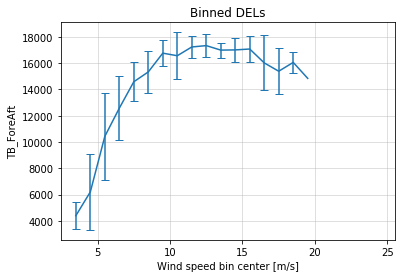

In [11]:
# create another plot with the binned DEL values
fig, ax = plt.subplots(figsize=(6,4))
ax.errorbar(bcenters,bin_DELs[variab],yerr=bin_DELs_std[variab],capsize=4,label='max')
ax.grid(alpha=0.5)
ax.set(xlabel='Wind speed bin center [m/s]',ylabel=variab,title='Binned DELs')